In [178]:
import numpy as np
import torch
import torch.nn as nn
import os

from PIL import Image, ImageOps
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from make_gif_from_folder import make_gif


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(0)
print(device)



cuda:0


In [180]:
class Net(nn.Module):
    def __init__(self, lr, img_path):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 4), nn.ELU(),
            nn.Linear(4, 8), nn.ELU(),
            nn.Linear(8, 16), nn.ELU(),
            nn.Linear(16, 32), nn.ELU(),
            # nn.Linear(32, 64), nn.ELU(),
            # nn.Linear(64, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 64), nn.ELU(),
            # nn.Linear(64, 32), nn.ELU(),
            # nn.Linear(32, 16), nn.ELU(),
            # nn.Linear(16, 8), nn.ELU(),
            nn.Linear(32, 1), nn.Tanh())
        
        self.lr = lr
        self.img_path = img_path
        
    def forward(self, x):
        #x = x.cuda()
        output = self.net(x)
        return output


In [181]:
def get_grayscale_image_arr(path):
    im = ImageOps.grayscale(Image.open(path))
    image_array = np.array(im).astype(int)
    return image_array


In [182]:
model = Net(lr=1e-3, img_path='./imgs/x.bmp')
model.to(device)
model

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=16, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Tanh()
  )
)

In [183]:
img_arr = get_grayscale_image_arr(model.img_path)
width, height = img_arr.shape
pix_num = width * height
bound_length = len(np.where(img_arr < 255)[0])
print(f'Total pixels: {pix_num}, bound length: {bound_length}, percent of bound pixels: {100 * bound_length / pix_num}%')

Total pixels: 45720, bound length: 3110, percent of bound pixels: 6.802274715660542%


In [184]:
optimizer = torch.optim.Adam(model.parameters(), lr=model.lr, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=100)

In [185]:
def loss_fn(y, data, epoch):
    mask = np.where(img_arr == 255)
    bound_mask = np.where(img_arr < 255)
    
    first_integral = 1 - (y[mask].abs()).sum() / (pix_num - bound_length) # хочу НЕ границу +-1
    #d_bound = (data.grad[d_bound_mask, :].abs() / data.grad[d_bound_mask, :].max()).sum() / len(data.grad[d_bound_mask, :]) if epoch else 0
    #d_bound = ((data.grad[d_bound_mask, :] / data.grad[d_bound_mask, :].max()) / len(data.grad[d_bound_mask, :])).sum() if epoch else 0
    #if epoch > 1000:
    # boundgrad = data.grad[np.where(img_arr.reshape(-1, 1) < 255), :]
    # boundgrad = 1. / boundgrad.view(-1, 1).abs().sum() 
    # outgrad = data.grad[np.where(img_arr.reshape(-1, 1) == 255), :]
    # outgrad = outgrad.view(-1, 1).abs().sum() / (len(outgrad.view(-1, 1)))
    # else:
    #     mygrad = 0
    second_integral = y.sum().abs() / pix_num #if epoch < 5000 else 0
    bound_intgegral = (y[bound_mask] ** 2).sum() / bound_length # хочу на границе 0

    
    return bound_intgegral + first_integral #+ 1e-1*second_integral# + boundgrad + outgrad #second_integral #+ mygrad 


In [186]:
def train_model(model, num_epochs):
    loss_trace = []

    batch = torch.tensor(np.array(np.stack(np.indices((width, height)), axis=2)).reshape(-1,2), device=device).float()
    batch[:, 0] -= batch[:, 0].mean()
    batch[:, 0] /= batch[:, 0].max()
    batch[:, 1] -= batch[:, 1].mean()
    batch[:, 1] /= batch[:, 1].max()
    #permutation = torch.randperm(batch.size()[0])
    #batch = batch[permutation]
    #batch.requires_grad_()
    
    dir_path = 'epoch_outs'
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    for epoch in range(num_epochs):
        y_pred = model(batch)
        #y_pred.sum().backward(retain_graph=True)
        y_pred = y_pred.view((width, height))
        
        optimizer.zero_grad() 
        
        loss = loss_fn(y_pred, batch, epoch)#, permutation) 
        loss_trace.append(loss.item())
        loss.backward()
         
        optimizer.step() 
        #scheduler.step(loss)
        
        if (epoch + 1) % 100 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            #plt.ylim((0, 1))
            plt.plot(loss_trace)
            plt.subplot(1, 2, 2)
            plt.imshow(y_pred.cpu().detach().numpy(), cmap='gray', vmin=-1, vmax=1)
            plt.title(f'Epoch {epoch + 1}')
            plt.savefig(dir_path + '/epoch%06d.png' % (epoch + 1))
            plt.show()
            
    return y_pred

In [187]:
# for g in optimizer.param_groups:
#     g['lr'] = 1e-4

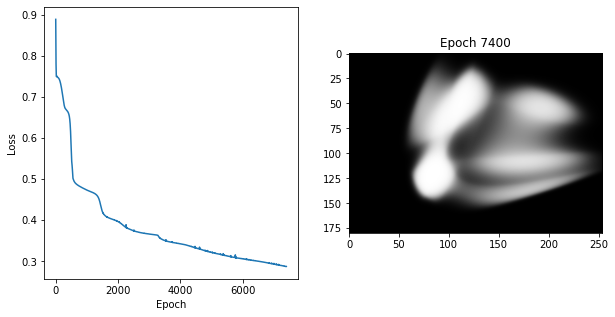

KeyboardInterrupt: 

In [188]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
y_pred = train_model(model=model, num_epochs=100000)

In [90]:
make_gif(dir_path='./epoch_outs', gifname='6_test')

In [11]:
batch = torch.tensor(np.array(np.stack(np.indices((width, height)), axis=2)).reshape(-1,2), device=device).float()
batch[:, 0] -= batch[:, 0].mean()
batch[:, 0] /= batch[:, 0].max()
batch[:, 1] -= batch[:, 1].mean()
batch[:, 1] /= batch[:, 1].max()
batch.requires_grad_()

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9747],
        [-1.0000, -0.9494],
        ...,
        [ 1.0000,  0.9494],
        [ 1.0000,  0.9747],
        [ 1.0000,  1.0000]], device='cuda:0', requires_grad=True)

In [12]:
y_pred = model(batch)
y_pred = y_pred.view((width, height))

In [13]:
a = loss_fn(y_pred, batch, 0)

In [14]:
a.backward()

In [15]:
mask = np.where(img_arr == 255)
bound_mask = np.where(img_arr < 255)
d_bound_mask = np.where(img_arr.reshape(-1, 1) == 255)

In [17]:
batch.grad[d_bound_mask, :].abs().sum()

tensor(1.2670, device='cuda:0')

In [84]:
batch = torch.tensor(np.array(np.stack(np.indices((width, height)), axis=2)).reshape(-1,2), device=device).float()
batch[:, 0] -= batch[:, 0].mean()
batch[:, 0] /= batch[:, 0].max()
batch[:, 1] -= batch[:, 1].mean()
batch[:, 1] /= batch[:, 1].max()

In [65]:
import random

In [76]:
random.shuffle(batch)

In [80]:
batch[1]

tensor([-1.0000, -1.0000], device='cuda:0')

In [86]:
batch[torch.randperm(batch.size()[0]), :]

tensor([[ 0.1955,  0.4071],
        [ 0.4637,  0.3597],
        [ 0.3408, -0.7154],
        ...,
        [-0.5419, -0.6522],
        [-0.5866, -0.9605],
        [ 0.3296,  0.2253]], device='cuda:0')

In [140]:
batch = torch.tensor(np.array(np.stack(np.indices((width, height)), axis=2)).reshape(-1,2), device=device).float()
batch[:, 0] -= batch[:, 0].mean()
batch[:, 0] /= batch[:, 0].max()
batch[:, 1] -= batch[:, 1].mean()
batch[:, 1] /= batch[:, 1].max()
batch = batch[torch.randperm(batch.size()[0])]

In [141]:
batch.size()

torch.Size([45720, 2])